In [ ]:
"""
calculate transition matrix for the whole week 
"""

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division  
import networkx as nx 
import pydot
import graphviz

In [2]:
# read data for ech week day
monday = pd.read_csv("./data/monday.csv",sep=";", parse_dates=True)

tuesday = pd.read_csv("./data/tuesday.csv", sep=";", parse_dates=True)

wednesday = pd.read_csv("./data/wednesday.csv", sep=";", parse_dates=True)

thursday = pd.read_csv("./data/thursday.csv", sep=";", parse_dates=True)

friday = pd.read_csv("./data/thursday.csv",sep=";", parse_dates=True)


In [3]:
monday

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices
...,...,...,...
4879,2019-09-02 21:49:00,1442,checkout
4880,2019-09-02 21:49:00,1444,checkout
4881,2019-09-02 21:49:00,1445,dairy
4882,2019-09-02 21:50:00,1446,dairy


In [4]:
""" add weekday column """
monday["weekday"] = "monday"
tuesday["weekday"] = "tuesday"
wednesday["weekday"] = "wednesday"
thursday["weekday"] = "thursday"
friday["weekday"] = "friday"

In [5]:
"""Edit customer no to include the weekday in order to make it unique"""
def edit_customer_no(df, weekday):
    df["customer_no"] = df["customer_no"].apply(lambda x: str(x)+"_"+weekday)

In [6]:
edit_customer_no(monday, "monday")
edit_customer_no(tuesday, "tuesday")
edit_customer_no(wednesday, "wednesday")
edit_customer_no(thursday, "thursday")
edit_customer_no(friday, "friday")

In [7]:
"""there is no checkout state for the last customers of the day so this should be fixed"""

def add_missing_checkout_state(df):

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.set_index("timestamp", inplace=True)

    checkout_customers = set(df[df["location"] == "checkout"]
                   ["customer_no"].unique())
    whole_customers = set(df["customer_no"].unique())
    diff = whole_customers.difference(checkout_customers)

    date = df.index.date[0]
    new_time_stemp = f"{date} 22:00:00"

    df.reset_index(inplace=True)

    for customer in diff:
        df = df.append({"timestamp": pd.to_datetime(new_time_stemp),
                            "customer_no": customer,
                            "location": "checkout"},
                            ignore_index=True)
    return df

In [8]:
monday = add_missing_checkout_state(monday)
tuesday = add_missing_checkout_state(tuesday)
wednesday = add_missing_checkout_state(wednesday)
thursday = add_missing_checkout_state(thursday)
friday = add_missing_checkout_state(friday)

In [9]:
friday

,timestamp,customer_no,location,weekday
0,2019-09-05 07:00:00,1_friday,drinks,friday
1,2019-09-05 07:01:00,2_friday,fruit,friday
2,2019-09-05 07:01:00,3_friday,dairy,friday
3,2019-09-05 07:01:00,4_friday,dairy,friday
4,2019-09-05 07:02:00,1_friday,checkout,friday
...,...,...,...,...
5102,2019-09-05 21:49:00,1534_friday,checkout,friday
5103,2019-09-05 21:49:00,1535_friday,checkout,friday
5104,2019-09-05 22:00:00,1532_friday,checkout,NaN
5105,2019-09-05 22:00:00,1533_friday,checkout,NaN


In [10]:
"""add initial state: the customers start from entrance state"""
def add_entrance_state(df):
    min_datetime = df.groupby("customer_no")["timestamp"].first().reset_index()
    one_minute = datetime.timedelta(minutes=1)

    for i in range(min_datetime.shape[0]):
        df = df.append({"timestamp": min_datetime["timestamp"].iloc[i] - one_minute, 
                            "customer_no": min_datetime["customer_no"].iloc[i],
                            "location": "entrance"},
                            ignore_index=True)
    return df

In [11]:
monday = add_entrance_state(monday)
tuesday = add_entrance_state(tuesday)
wednesday = add_entrance_state(wednesday)
thursday = add_entrance_state(thursday)
friday = add_entrance_state(friday)

In [12]:
"""get a dataframe for the whole week"""
week_data = pd.concat([monday, tuesday, wednesday, thursday, friday])
week_data.set_index("timestamp", inplace=True)

In [13]:
week_data

,customer_no,location,weekday
timestamp,,,
2019-09-02 07:03:00,1_monday,dairy,monday
2019-09-02 07:03:00,2_monday,dairy,monday
2019-09-02 07:04:00,3_monday,dairy,monday
2019-09-02 07:04:00,4_monday,dairy,monday
2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...
2019-09-05 17:20:00,997_friday,entrance,NaN
2019-09-05 17:21:00,998_friday,entrance,NaN
2019-09-05 17:22:00,999_friday,entrance,NaN


In [14]:
#group data by customer 
week_data = week_data.groupby("customer_no").resample(rule="1T").ffill()

In [15]:
week_data

customer_no  location    weekday
customer_no timestamp                                            
1000_friday 2019-09-05 17:22:00  1000_friday  entrance        NaN
            2019-09-05 17:23:00  1000_friday    spices     friday
            2019-09-05 17:24:00  1000_friday    spices     friday
            2019-09-05 17:25:00  1000_friday    spices     friday
            2019-09-05 17:26:00  1000_friday     dairy     friday
...                                      ...       ...        ...
9_tuesday   2019-09-03 07:29:00    9_tuesday     dairy    tuesday
            2019-09-03 07:30:00    9_tuesday  checkout    tuesday
9_wednesday 2019-09-04 07:02:00  9_wednesday  entrance        NaN
            2019-09-04 07:03:00  9_wednesday    spices  wednesday
            2019-09-04 07:04:00  9_wednesday  checkout  wednesday

[61690 rows x 3 columns]

In [16]:
#get the next transition for every customer
del week_data["customer_no"]
week_data.reset_index(inplace=True)
week_data.sort_values(["customer_no", "timestamp"], inplace=True)
week_data["after"] = week_data["location"].shift(-1)
week_data.rename(columns={"location":"before"},inplace=True)
week_data

,customer_no,timestamp,before,weekday,after
0,1000_friday,2019-09-05 17:22:00,entrance,NaN,spices
1,1000_friday,2019-09-05 17:23:00,spices,friday,spices
2,1000_friday,2019-09-05 17:24:00,spices,friday,spices
3,1000_friday,2019-09-05 17:25:00,spices,friday,dairy
4,1000_friday,2019-09-05 17:26:00,dairy,friday,dairy
...,...,...,...,...,...
61685,9_tuesday,2019-09-03 07:29:00,dairy,tuesday,checkout
61686,9_tuesday,2019-09-03 07:30:00,checkout,tuesday,entrance
61687,9_wednesday,2019-09-04 07:02:00,entrance,NaN,spices
61688,9_wednesday,2019-09-04 07:03:00,spices,wednesday,checkout


In [17]:
#the next transition for checkout state is checkout state
week_data.loc[(week_data.before == 'checkout'), 'after'] = 'checkout'

In [18]:
transitions=week_data[["before","after"]]
transitions

,before,after
0,entrance,spices
1,spices,spices
2,spices,spices
3,spices,dairy
4,dairy,dairy
...,...,...
61685,dairy,checkout
61686,checkout,checkout
61687,entrance,spices
61688,spices,checkout


In [19]:
# calculate transition probabilities matrix
transition_matrix = pd.crosstab(week_data['before'],
                                week_data['after'],
                                normalize=0)
transition_matrix

after,checkout,dairy,drinks,fruit,spices
before,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.102043,0.740514,0.056666,0.050058,0.050719
drinks,0.217556,0.011395,0.595168,0.088943,0.086938
entrance,0.000000,0.293976,0.150870,0.373494,0.181660
fruit,0.204200,0.092540,0.052265,0.599906,0.051089
spices,0.149425,0.193198,0.159660,0.088805,0.408912


In [20]:
# check if the matrix is correct
transition_matrix.sum(axis=1)

before
checkout    1.0
dairy       1.0
drinks      1.0
entrance    1.0
fruit       1.0
spices      1.0
dtype: float64

In [21]:
# export the transition probabilities matrix to csv
transition_matrix.to_csv("./data/transition_matrix.csv")
print(transition_matrix)

after     checkout     dairy    drinks     fruit    spices
before                                                    
checkout  1.000000  0.000000  0.000000  0.000000  0.000000
dairy     0.102043  0.740514  0.056666  0.050058  0.050719
drinks    0.217556  0.011395  0.595168  0.088943  0.086938
entrance  0.000000  0.293976  0.150870  0.373494  0.181660
fruit     0.204200  0.092540  0.052265  0.599906  0.051089
spices    0.149425  0.193198  0.159660  0.088805  0.408912


<AxesSubplot:xlabel='after', ylabel='before'>

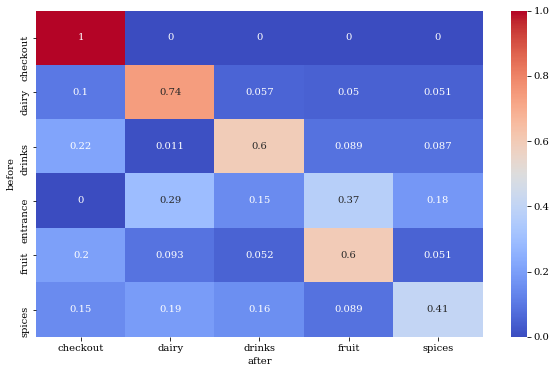

In [22]:
#Visualize the probabilities as a heat map
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.rcParams['font.family'] = "serif"
sns.heatmap(transition_matrix,cmap='coolwarm', annot=True)

In [23]:
Q = pd.read_csv('data/transition_matrix.csv', index_col=0)
Q=Q.round(2)

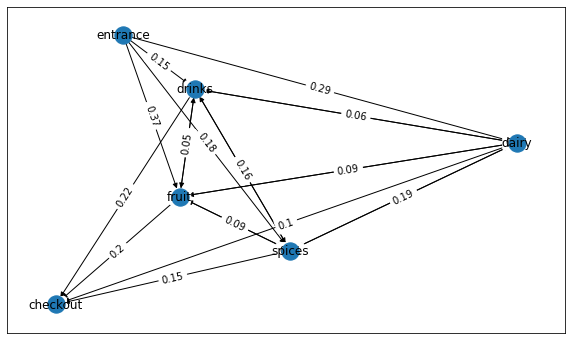

In [24]:
states = ['entrance','drinks','dairy','fruit','spices','checkout']

# create a function that maps transition probability dataframe
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(Q)

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)

# edges represent transition probabilities
for k, v in edges_wts.items():

    if v > 0.0:
        tmp_origin, tmp_destination = k[0], k[1]
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)
# create edge labels for jupyter plot
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'data/markov.dot')

(graph,) = pydot.graph_from_dot_file('data/markov.dot')
graph.write_png('data/markov.png')

In [25]:
# aisles visited first
week_data['firsts'] = week_data.duplicated('customer_no')
firsts = week_data[week_data['firsts'] == False]
# initial_state_vector
initial_state_abs = firsts.groupby('before').count()['customer_no']
initial_state_vector = initial_state_abs/initial_state_abs.sum()


before
entrance    1.0
Name: customer_no, dtype: float64